In [1]:
%reset
#%qtconsole
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib.pyplot as plt
import functions as fun

import numpy as np
import matplotlib as mpl
from scipy import stats

from scipy.interpolate import interp1d,interp2d
from scipy.optimize import least_squares

import pandas as pd





Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
sigma_t=0.01; # Input noise, determine how smooth the single neuron transfer function is 
tau_rp=0.002; # Refractory period

g_E=8.; g_I=3;beta=1.; # parameters characterizing the relative strength of synaptic connections
K=500*4; # average number of E connections per neuron (I connections are 1/4 of that)
sigma_Lambda_over_Lambda=1; # ratio between mean and standard deviation of the opsin expression
#sigma_Lambda_over_Lambda=0.5; # ratio between mean and standard deviation of the opsin expression

L=[0.,  20. ]; #  Laser intensity that fits the data
r_X=20*np.ones(1)
#[20,20,20]; # To speed up the code, I show results onlye for low anf high contrast and laser

Tmax_over_tau_E=100;
#Tmax_over_tau_E=15;

p=0.1; # probability of connection between cells. 
sigma_X_over_r_X=0.2; # Presynaptic population has mean rate r_X, Gaussianly distributed with std=0.2* r_X
Lambda=1*10**-3; # mean opsin expression in Volt

sigma_Lambda=sigma_Lambda_over_Lambda*Lambda


N=int(K/p);
N_E,N_I=N,int(N*fun.gamma);
N_X=N_E+N_I

In [5]:
J=0.0006
(sigma_Lambda*L[-1])**2/K/J**2

0.5555555555555557

In [348]:
'''
mu_tab_max=10.0;
mu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)
mu_tab=np.concatenate(([-10000],mu_tab))
mu_tab=np.concatenate((mu_tab,[10000]))

phi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;
for idx in range(len(phi_tab_E)):
    phi_tab_E[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_E,tau_rp,sigma_t)
    phi_tab_I[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_I,tau_rp,sigma_t)

phi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  
phi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')
'''

"\nmu_tab_max=10.0;\nmu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)\nmu_tab=np.concatenate(([-10000],mu_tab))\nmu_tab=np.concatenate((mu_tab,[10000]))\n\nphi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;\nfor idx in range(len(phi_tab_E)):\n    phi_tab_E[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_E,tau_rp,sigma_t)\n    phi_tab_I[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_I,tau_rp,sigma_t)\n\nphi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  \nphi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')\n"

In [349]:
print('Computing and saving network response')
T=np.arange(0,Tmax_over_tau_E*fun.tau_E,fun.tau_I/3);

#mask_time=T>(10*fun.tau_E)
mask_time=T>(T/2)

# Generate quenched disorder
Possible_J=[0.00002,0.0006]#,0.0007,0.0008]#10**np.linspace(-5,-3,20); # Synaptic efficacy in Volts


RATES=-1*np.ones((len(Possible_J),len(L),N_E+N_I))
DYNA=-1*np.ones((len(Possible_J),len(L),N_E+N_I,len(T)))
MUS=-1*np.ones((len(Possible_J),len(L),N_E+N_I))
Lambda_i_L=1./tau_rp*np.ones((len(Possible_J),len(L),N_E+N_I))
MFT_SOL_R=np.ones((len(Possible_J),len(L),10))
MFT_SOL_M=np.ones((len(Possible_J),len(L),10))
Phi=[phi_int_E,phi_int_I];
for idx_J in [0,1]:#range(len(Possible_J)):

    G_E,G_I=1.0,2.0 # Gain of Excitatory and inhibitory cells and I cells
    w_EE=1;w_IE=w_EE/beta;
    w_EI=g_E*w_EE;w_II=g_I*w_IE;
    
    w_EX,w_IX=(G_I*fun.gamma*g_E-G_E)*w_EE,(G_I*fun.gamma*g_I-G_E)*w_IE; 
    J=Possible_J[idx_J]*np.sqrt(500/K)
    if idx_J==0:
        w_X=np.asarray([w_EX,5*w_IX]);
        #w_X=np.asarray([w_EX,w_IX]);
    if idx_J>0:
        w_X=np.asarray([w_EX,w_IX]);
    print(w_X)
    w=np.zeros((2,2));
    w[0,:]=w_EE,-w_EI
    w[1,:]=w_IE,-w_II

    M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun.Generate_quenched_disorder(sigma_X_over_r_X,J,K,w,w_X,p,Lambda,sigma_Lambda)

    print(w*J)
    
    for idx_L in range(len(L)):
        r_X_local,L_local=r_X[0],L[idx_L];
        print((idx_J+1)/len(Possible_J),(idx_L+1)/len(L))
        DYNA[idx_J,idx_L,:,:], MUS[idx_J,idx_L,:],Lambda_i_L[idx_J,idx_L,:]=fun.High_dimensional_dynamics(T,L_local,r_X_local,M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I,phi_int_E,phi_int_I);
        RATES[idx_J,idx_L,:]=np.mean(DYNA[idx_J,idx_L,:,mask_time],axis=0)
        print(np.mean(RATES[idx_J,idx_L,0:N_E]),
              np.mean(RATES[idx_J,idx_L,N_E::]),
              np.std(RATES[idx_J,idx_L,0:N_E]),
              np.std(RATES[idx_J,idx_L,N_E::]))
    Base_Sim=RATES[idx_J,0,:]
    Delta_Sim=RATES[idx_J,idx_L,:]-RATES[idx_J,0,:]

    moments_of_r_sim=np.zeros(5)
    moments_of_r_sim[0]=np.mean(Base_Sim)
    moments_of_r_sim[1]=np.mean(Delta_Sim)
    moments_of_r_sim[2]=np.std(Base_Sim)
    moments_of_r_sim[3]=np.std(Delta_Sim)
    moments_of_r_sim[4]=np.cov(Base_Sim,Delta_Sim)[0,1]
    print(moments_of_r_sim[:])

    

Computing and saving network response
[3.  2.5]
[[ 1.e-05 -8.e-05]
 [ 1.e-05 -3.e-05]]
0.5 0.5
17.148694193548796 23.276671123224833 2.322116749926576 1.0846538051652286
0.5 1.0
68.7966968010368 51.860264471598455 49.168219767112916 2.850585589223075
[ 18.37428958  47.03512076   3.24921713  44.77241313 -16.79832978]
[3.  0.5]
[[ 0.0003 -0.0024]
 [ 0.0003 -0.0009]]
1.0 0.5
25.04213666130956 44.494987642118765 57.65936656060001 50.58858439653227
1.0 1.0
26.324118416210347 46.1371361989163 61.40600926024263 51.91886755688456
[  28.93270686    1.35401512   56.85128989   37.40674858 -506.44673424]


In [362]:
idx_J=1;
J=Possible_J[idx_J]*np.sqrt(500/K)
print(J,w*J)

0.0003 [[ 0.0003 -0.0024]
 [ 0.0003 -0.0009]]


In [369]:
w_EX,w_IX=(G_I*fun.gamma*g_E-G_E)*w_EE,(G_I*fun.gamma*g_I-G_E)*w_IE
print(w_EX,w_IX,w_IX*5)

3.0 0.5 2.5


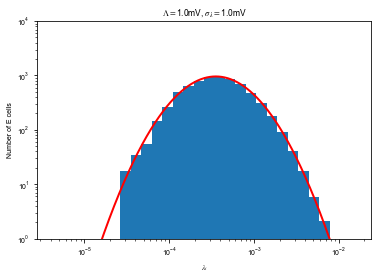

In [351]:
J=0.000001
sigma_l=np.sqrt(np.log(1+sigma_Lambda_over_Lambda**2))
mu_l=np.log(Lambda)-sigma_l**2/2


count, bins, ignored = plt.hist(Lambda_i[0:N_E], 
                                10**np.linspace(np.log10(np.min(Lambda_i[0:N_E])*0.1),np.log10(1.1*np.max(Lambda_i[0:N_E])),33), 
                                density=True, align='mid')

plt.title(r'$\Lambda=$%.1fmV, $\sigma_\lambda=$%.1fmV'%(np.mean(Lambda_i[0:N_E])*10**3,np.std(Lambda_i[0:N_E])*10**3))
x = 10**np.linspace(min(np.log10(bins*0.5)), max(np.log10(bins*1.5)), 10000)
pdf = (np.exp(-(np.log(x) - mu_l)**2 / (2 * sigma_l**2))
       / (x * sigma_l * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda_i$')
plt.ylabel('Number of E cells')
plt.xlim([np.min(Lambda_i[0:N_E])*0.1,(1.1*np.max(Lambda_i[0:N_E]))])
plt.ylim([1,10**4])
plt.show()

<ipython-input-352-083da2bee088>:48: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)
<ipython-input-352-083da2bee088>:48: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)


0.0028922749695132043
0.3125943034406469
-0.3578149664995713
-0.40547599696331255


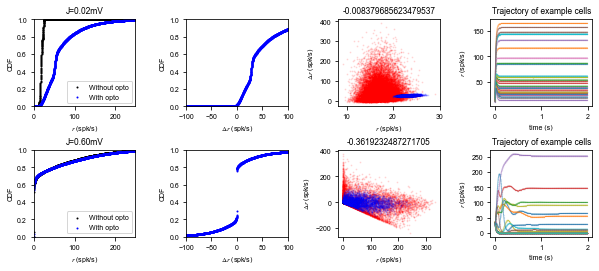

In [352]:
bin_edges=np.arange(0,1./tau_rp,.1)
spacings=np.diff(bin_edges)[0];
bin_means=0.5*(bin_edges[0:-1]+bin_edges[1::])
bin_edges_Delta=np.arange(-1./tau_rp,1./tau_rp,.1)
spacings_Delta=np.diff(bin_edges)[0];
bin_means_Delta=0.5*(bin_edges_Delta[0:-1]+bin_edges_Delta[1::])

fig, axs = plt.subplots(len(Possible_J),4, figsize=(2.5*4,2.0*len(Possible_J)), facecolor='w', edgecolor='k')#,sharey='row')#,sharex=True)
fig.subplots_adjust(hspace = .5, wspace=.5)
area=1.0;linethicknes=1.0;
axs = axs.ravel()
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

for idx_J in range(len(Possible_J)):
    J=Possible_J[idx_J]
    maks_cells=(RATES[idx_J,1,:]+RATES[idx_J,0,:])>=0

    color=['k','b',];
    idx_cell=0;
    sol_M=MFT_SOL_M[idx_J,idx_L,:]
    mu,S2_mu=sol_M[idx_cell],sol_M[idx_cell+2]
    delta_mu,S2_delta_mu,Cov_mu_delta_mu=sol_M[idx_cell+4],sol_M[idx_cell+6],sol_M[idx_cell+8]
    Frac=[1,0]
    label=['Without opto','With opto']
    for idx_L in range(len(L)):
        #hist, bin_edges=np.histogram(RATES[idx_J,idx_L,0:N_E],bin_edges)#,normed=True)
        hist, bin_edges=np.histogram(RATES[idx_J,idx_L,maks_cells],bin_edges)#,normed=True)
        bin_mean=0.5*(bin_edges[0:-1]+bin_edges[1::])
        spacings=np.diff(bin_edges)[0];
        hist=hist/np.sum(hist*spacings)
        axs[idx_J*4+0].scatter(bin_mean,np.cumsum(spacings*hist),c=color[idx_L],s=area,label=label[idx_L])
    '''    
        P_of_nu=fun.P_of_r_A(bin_edges,Phi[idx_cell],
                       mu,S2_mu,delta_mu,
                       S2_delta_mu,Cov_mu_delta_mu,
                       L[idx_L],Lambda,sigma_Lambda,Frac[idx_cell]);
        axs[idx_J*4+0].plot(bin_mean,np.cumsum(P_of_nu[:]*spacings),c='purple')    
    '''
    #Delta_Sim=RATES[idx_J,1,0:N_E]-RATES[idx_J,0,0:N_E]

    Delta_Sim=RATES[idx_J,1,maks_cells]-RATES[idx_J,0,maks_cells]
    hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)
    CDF_Resp_Delta=np.cumsum(hist_Delta*spacings_Delta)
    axs[idx_J*4+1].scatter(bin_means_Delta,CDF_Resp_Delta,c='b',s=area);

    idx_cells=np.where((np.arange(len(Lambda_i))<N_E))
    axs[idx_J*4+2].scatter(RATES[idx_J,0,idx_cells],RATES[idx_J,1,idx_cells]-RATES[idx_J,0,idx_cells],c='r',s=1,alpha=0.1);
    pippo=np.cov(RATES[idx_J,0,idx_cells],RATES[idx_J,1,idx_cells]-RATES[idx_J,0,idx_cells])
    print(pippo[0,1]/pippo[1,1])
    idx_cells=np.where((np.arange(len(Lambda_i))>N_E))
    axs[idx_J*4+2].scatter(RATES[idx_J,0,idx_cells],RATES[idx_J,1,idx_cells]-RATES[idx_J,0,idx_cells],c='b',s=1,alpha=0.1);
    pippo=np.cov(RATES[idx_J,0,idx_cells],RATES[idx_J,1,idx_cells]-RATES[idx_J,0,idx_cells])
    print(pippo[0,1]/pippo[1,1])
    
    cov=np.cov(RATES[idx_J,0,:],RATES[idx_J,1,:]-RATES[idx_J,0,:])
    axs[idx_J*4+2].set_title(cov[0,1]/cov[1,1])
    '''
    P_of_nu=fun.P_of_delta_r_A(bin_edges_Delta,Phi[idx_cell],
                       mu,S2_mu,delta_mu,
                       S2_delta_mu,Cov_mu_delta_mu,
                       L[1],Lambda,sigma_Lambda,Frac[idx_cell]);

    axs[1].plot(bin_means_Delta,np.cumsum(P_of_nu*spacings_Delta),c='purple')
    '''


    for idx_cell in range(31):
        axs[idx_J*4+3].plot(T[mask_time]-T[mask_time][0],DYNA[idx_J,1,idx_cell,mask_time],marker='o',markersize=0.1,alpha=0.5)

    axs[idx_J*4+0].axis([0,250,.0,1.])
    axs[idx_J*4+0].legend(loc='lower right')
    axs[idx_J*4+1].axis([-100,100,0,1.])
    axs[idx_J*4+0].set_title('J=%.2fmV'%(J*10**3))
    axs[idx_J*4+0].set_ylabel('CDF')
    axs[idx_J*4+1].set_ylabel('CDF')
    axs[idx_J*4+0].set_xlabel('$r$ (spk/s)')
    axs[idx_J*4+1].set_xlabel('$\Delta r$ (spk/s)')
    axs[idx_J*4+2].set_ylabel('$\Delta r$ (spk/s)')
    axs[idx_J*4+2].set_xlabel('$r$ (spk/s)')
    axs[idx_J*4+3].set_ylabel('$r$ (spk/s)')
    axs[idx_J*4+3].set_xlabel('time (s)')
    axs[idx_J*4+3].set_title('Trajectory of example cells')



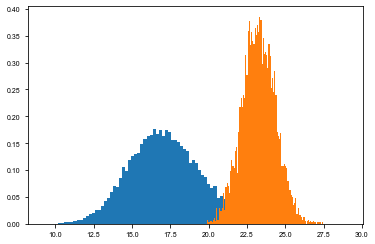

In [353]:
idx_J=0;idx_L=0
plt.hist(RATES[idx_J,idx_L,0:N_E],100,density=True);
plt.hist(RATES[idx_J,idx_L,N_E::],100,density=True);

In [354]:
params=[sigma_t,tau_rp,g_E,g_I,beta,K,sigma_Lambda_over_Lambda,L[1],r_X[0],Tmax_over_tau_E,p,sigma_X_over_r_X,Lambda,N_E,N_I]

np.save('simulations/RATES',RATES)
np.save('simulations/params',params)
np.save('simulations/Possible_J',Possible_J)




In [7]:
mu_tab_max=10.0;
mu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)
mu_tab=np.concatenate(([-10000],mu_tab))
mu_tab=np.concatenate((mu_tab,[10000]))

phi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;
for idx in range(len(phi_tab_E)):
    phi_tab_E[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_E,tau_rp,sigma_t)
    phi_tab_I[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_I,tau_rp,sigma_t)

phi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  
phi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')

/Users/ale/Dropbox/research/Laser_on_E_cells/Draft_figures_simulations/Figure_3/v2/functions.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  adelleh=integrate.quad(lambda u: f(u),minimo,massimo)
/Users/ale/Dropbox/research/Laser_on_E_cells/Draft_figures_simulations/Figure_3/v2/functions.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  adelleh=integrate.quad(lambda u: f(u),minimo,massimo)


(0.0, 100.0)

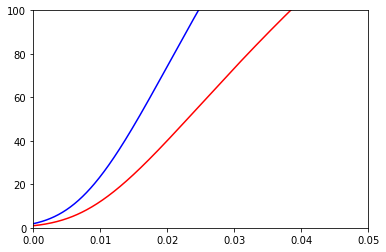

In [11]:
plt.plot(mu_tab, phi_tab_E,c='r')
plt.plot(mu_tab, phi_tab_I,c='b')
plt.xlim([-0.,0.05])
plt.ylim([0,100])